In [2]:
from peewee import Model as ORMModel, IntegerField, TextField, BlobField, FloatField, SqliteDatabase, fn as sql_fn
import base64
import numpy as np
import chess

db = SqliteDatabase("../datasets/2021-07-31-lichess-evaluations-37MM.db/test.db")

def fen_as_input(fen: str):
    board = chess.Board(fen)
    inputs = np.zeros(65, dtype=np.float16)
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            inputs[i] = piece.piece_type * (1 if piece.color == chess.WHITE else -1)
    inputs[64] = 1 if board.turn == chess.WHITE else -1 # forgor this earlier ☠
    return inputs

class Evaluations(ORMModel):
    id = IntegerField()
    fen = TextField()
    binary = BlobField()
    eval = FloatField()

    class Meta:
        database = db

    def binary_base64(self):
        return base64.b64encode(self.binary)
    
    def as_input(self):
        return fen_as_input(self.fen)
    
    def display(self):
        from IPython.display import display, SVG
        SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/"
        fen_board = self.fen.split()[0]
        display(SVG(url=SVG_BASE_URL + fen_board))

db.connect()

True

In [3]:
LABEL_COUNT = Evaluations.select().count()
print(LABEL_COUNT) 

37164639


In [4]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
import pytorch_lightning as pl
from random import randrange

class EvaluationDataset(IterableDataset):
  def __init__(self, count):
    self.count = count
  def __iter__(self):
    return self
  def __next__(self):
    idx = randrange(self.count)
    return self[idx]
  def __len__(self):
    return self.count
  def __getitem__(self, idx):
    eval = Evaluations.get(Evaluations.id == idx+1)
    # bin = np.frombuffer(eval.binary, dtype=np.uint8)
    # bin = np.unpackbits(bin, axis=0).astype(np.single)
    eval.eval = max(eval.eval, -15)
    eval.eval = min(eval.eval, 15)
    ev = np.array([eval.eval]).astype(np.single)
    input = eval.as_input()
    return {'input': input, 'eval':ev}

dataset = EvaluationDataset(count=LABEL_COUNT)

c:\Users\TeamD\.conda\envs\chess2\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [ ]:
Evaluations.select()

In [31]:
[next(dataset) for _ in range(10000)]

[{'input': array([ 0.,  0.,  4.,  0.,  0.,  4.,  6.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
          0., -1., -1.,  1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
          0., -1.,  0., -6., -3.,  3.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -4.,  0., -4.,  1.],
        dtype=float16),
  'eval': array([-4.11], dtype=float32)},
 {'input': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -6.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  1.],
        dtype=float16),
  'eval': array([15.], dtype=float32)},
 {'input': array([ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0., -4.,  0.,  0.,
          0.,  1.,  0.,  0.

In [34]:
random_rows = Evaluations.select().order_by(sql_fn.Random()).limit(10000)
list(random_rows)

[<Evaluations: 26248376>,
 <Evaluations: 1752224>,
 <Evaluations: 9868083>,
 <Evaluations: 31312988>,
 <Evaluations: 3492834>,
 <Evaluations: 7233927>,
 <Evaluations: 13185970>,
 <Evaluations: 27081786>,
 <Evaluations: 23805171>,
 <Evaluations: 32893930>,
 <Evaluations: 3634280>,
 <Evaluations: 20545039>,
 <Evaluations: 7389614>,
 <Evaluations: 8322353>,
 <Evaluations: 1632351>,
 <Evaluations: 2410374>,
 <Evaluations: 2164104>,
 <Evaluations: 2474993>,
 <Evaluations: 12085774>,
 <Evaluations: 12012814>,
 <Evaluations: 3024831>,
 <Evaluations: 17969023>,
 <Evaluations: 21945167>,
 <Evaluations: 3365089>,
 <Evaluations: 816028>,
 <Evaluations: 10739079>,
 <Evaluations: 18148101>,
 <Evaluations: 3337552>,
 <Evaluations: 20422169>,
 <Evaluations: 28379749>,
 <Evaluations: 352099>,
 <Evaluations: 5739058>,
 <Evaluations: 2956727>,
 <Evaluations: 4005289>,
 <Evaluations: 28449713>,
 <Evaluations: 1971967>,
 <Evaluations: 20049605>,
 <Evaluations: 9344941>,
 <Evaluations: 57070>,
 <Evaluation

In [36]:
list(Evaluations.select().limit(10000))

[<Evaluations: 1>,
 <Evaluations: 2>,
 <Evaluations: 3>,
 <Evaluations: 4>,
 <Evaluations: 5>,
 <Evaluations: 6>,
 <Evaluations: 7>,
 <Evaluations: 8>,
 <Evaluations: 9>,
 <Evaluations: 10>,
 <Evaluations: 11>,
 <Evaluations: 12>,
 <Evaluations: 13>,
 <Evaluations: 14>,
 <Evaluations: 15>,
 <Evaluations: 16>,
 <Evaluations: 17>,
 <Evaluations: 18>,
 <Evaluations: 19>,
 <Evaluations: 20>,
 <Evaluations: 21>,
 <Evaluations: 22>,
 <Evaluations: 23>,
 <Evaluations: 24>,
 <Evaluations: 25>,
 <Evaluations: 26>,
 <Evaluations: 27>,
 <Evaluations: 28>,
 <Evaluations: 29>,
 <Evaluations: 30>,
 <Evaluations: 31>,
 <Evaluations: 32>,
 <Evaluations: 33>,
 <Evaluations: 34>,
 <Evaluations: 35>,
 <Evaluations: 36>,
 <Evaluations: 37>,
 <Evaluations: 38>,
 <Evaluations: 39>,
 <Evaluations: 40>,
 <Evaluations: 41>,
 <Evaluations: 42>,
 <Evaluations: 43>,
 <Evaluations: 44>,
 <Evaluations: 45>,
 <Evaluations: 46>,
 <Evaluations: 47>,
 <Evaluations: 48>,
 <Evaluations: 49>,
 <Evaluations: 50>,
 <Evaluat

In [50]:
import chess.engine
engine = chess.engine.SimpleEngine.popen_uci(r"..\..\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe")

36656986


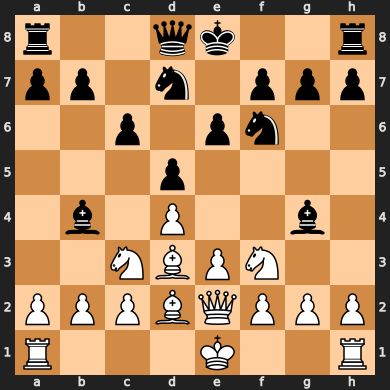

In [93]:
eval: Evaluations = Evaluations.get(Evaluations.id == randrange(LABEL_COUNT))
print(eval)
board = chess.Board(eval.fen)
board

In [94]:
info = engine.analyse(board, chess.engine.Limit(time=2.0))
print("engine", info["score"])
print("db", eval.eval)

engine PovScore(Cp(-56), WHITE)
db -0.77
